# Neural Network Approach on Titanic Dataset


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')
from IPython.display import Image

## 1. Import the train and test datasets
Explore the train and test dataset dimension

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print("Dimension of train table : ",train.shape)
print("Dimension of test table : ",test.shape)

Dimension of train table :  (891, 12)
Dimension of test table :  (418, 11)


## 2. Exploring the data
### Data dictionary
![title](datadictionary.png)
### Variable Notes
![title](variablenotes.png)

## 3. Explore and converting age column

eksplorasi categorical features seperti "Sex" dan "Pclass"

In [9]:
train["Age"].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

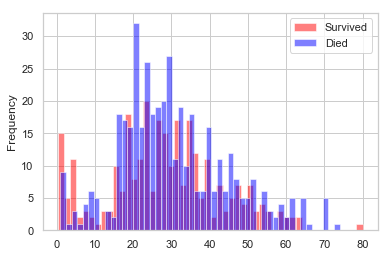

In [10]:
survived = train[train["Survived"]==1]
died = train[train["Survived"]==0]
survived["Age"].plot.hist(alpha=0.5,color='red',bins=50)
died["Age"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['Survived','Died']);

## 4. Separate continous feature into a categorical feature

Create function that :
* Use _pandas.fillna()_ method to fill all the missing value with _-0.5_
* Cuts the **Age** column into six segments :
    * **Missing**, from **-1** to **0**
    * **Infant**, from **0** to **5**
    * **Child**, from **5** to **12**
    * **Teenager**, from **12** to **18**
    * **Young Adult**, from **18** to **35**
    * **Adult**, from **35** to **60**
    * **Senior**, from **60** to **100**
    
The diagram below shows how the function converts the data :

![title](convertvalues.png)

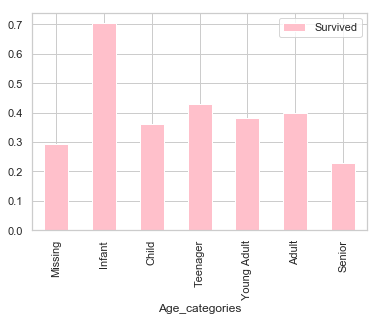

In [12]:
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels = label_names)
    return df

cut_points = [-1,0,5,12,18,35,60,100]
label_names = ["Missing", "Infant", "Child", "Teenager", "Young Adult", "Adult", "Senior"]

train = process_age(train, cut_points, label_names)
test = process_age(test, cut_points, label_names)

pivot = train.pivot_table(index="Age_categories", values='Survived')
pivot.plot.bar(color='pink');

## 5. Preparing data for Machine Learning

features columns that useful for predicting survival :

* **Sex**
* **Pclass**
* **Age**, atau setelah pengkategorian menjadi **Age_categories**

In [13]:
print("Pclass value counts : ");
train["Pclass"].value_counts()

Pclass value counts : 


3    491
1    216
2    184
Name: Pclass, dtype: int64

### Create dummy column

create dummy columns for the Pclass features
![title](pclassdummy.png)

In [14]:
def create_dummies(df, column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

for column in ["Pclass","Sex","Age_categories"]:
    train = create_dummies(train,column)
    test = create_dummies(test,column)

## Create Machine Learning Model

the model wil be using __Neural Network__ to perform classification
using _Scikit Learn_ library with these workflow :
* Instantiate the specific machine learning model
* FIt the model to the training data
* Use the model to make predictions
* Evaluate the accuracy of the predictions

In [22]:
columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

# Convert dataset to array
X = train[columns].values
y = train['Survived'].values

# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Show Dimension
X.shape

(891, 12)

In [46]:
import torch
from torch import nn, optim
import torch.nn.functional as F

# Define Neural Network
class Clasifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(12, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.fc4 = nn.Linear(10, 2)
        # Add dropout with 0,3 prob
        self.dropout = nn.Dropout(p=0.3)
    
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        # Output layer
        x = torch.sigmoid(self.fc4(x))
        return x

In [56]:
model = Clasifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

epochs = 50
steps = 0
batch_size = 50
batch_no = len(X_train) // batch_size

train_losses, test_losses = [], []

from sklearn.utils import shuffle
from torch.autograd import Variable

for epoch in range(epochs):
    running_loss = 0
    if epoch % 5 == 0:
        print ('Epoch {}'.format(epoch+1))
    X_train, y_train = shuffle(X_train, y_train)
    # Mini batch learning
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        x_var = Variable(torch.FloatTensor(X_train[start:end]))
        y_var = Variable(torch.LongTensor(y_train[start:end]))
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        y_pred_var = model(x_var)
        loss = criterion(y_pred_var, y_var)
        loss.backward()
        optimizer.step()
        

Epoch 1
Epoch 6
Epoch 11
Epoch 16
Epoch 21
Epoch 26
Epoch 31
Epoch 36
Epoch 41
Epoch 46


In [65]:
test_var = Variable(torch.FloatTensor(X_test), requires_grad=True)

with torch.no_grad():
    result = model(test_var)
    
values, labels = torch.max(result, 1)
num_right = np.sum(labels.data.numpy() == y_test)
print('Accuracy {}'.format(num_right / len(y_test)))

Accuracy 0.8156424581005587
